In [1]:
import pandas as pd
from orion import Orion
from utils import plot
from tensorflow.keras.utils import plot_model

In [6]:
data = pd.read_csv('data/543341.csv', usecols=['Date', 'No. of Trades'], parse_dates=['Date'])
data.rename(columns={'No. of Trades': 'value', 'Date': 'timestamp'}, inplace=True)
data.sort_values(by='timestamp', inplace=True)
data.timestamp = (data.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
data.head()

,timestamp,value
244,1647302400,3
243,1648166400,1
242,1648425600,1
241,1648512000,2
240,1648598400,2


In [7]:
known_anomalies = pd.DataFrame({
    'start': [1648751400],
    'end': [1661970599]
})

In [8]:
known_anomalies

,start,end
0,1648751400,1661970599


## LSTM Autoencoder

In [42]:
hyperparameters = {
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        'target_column': 0,
        'window_size': 100
    },
    'keras.Sequential.LSTMSeq2Seq#1': {
        'epochs': 15,
        'verbose': True,
        'window_size': 100,
        'input_shape': [100, 1],
        'target_shape': [100, 1]
    }
}

In [43]:
orion = Orion(
    pipeline='lstm_autoencoder',
    hyperparameters=hyperparameters
)

In [44]:
anomalies = orion.fit_detect(data)

Epoch 1/15
18/18 [==============================] - 4s 228ms/step - loss: 0.0912 - mse: 0.0912 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 2/15
18/18 [==============================] - 4s 197ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 3/15
18/18 [==============================] - 4s 196ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 4/15
18/18 [==============================] - 4s 197ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5/15
18/18 [==============================] - 4s 198ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 6/15
18/18 [==============================] - 4s 199ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 7/15
18/18 [==============================] - 4s 197ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 8/15
18/18 [==============================] - 4s 199ms/step - loss: 0.

In [45]:
anomalies

,start,end,severity
0,1653523200,1656288000,1.180358
1,1656633600,1660521600,0.273536


In [55]:
orion.evaluate(data=data, ground_truth=known_anomalies,
               metrics=['f1', 'recall', 'precision'])

22/22 [==============================] - 2s 85ms/step


f1           0.669565
recall       0.503268
precision    1.000000
dtype: float64

In [28]:
#Slice data after timestamp 1640975400
data_t = data[data.timestamp > 1640975400]
print(data_t.shape)

(296, 2)


/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


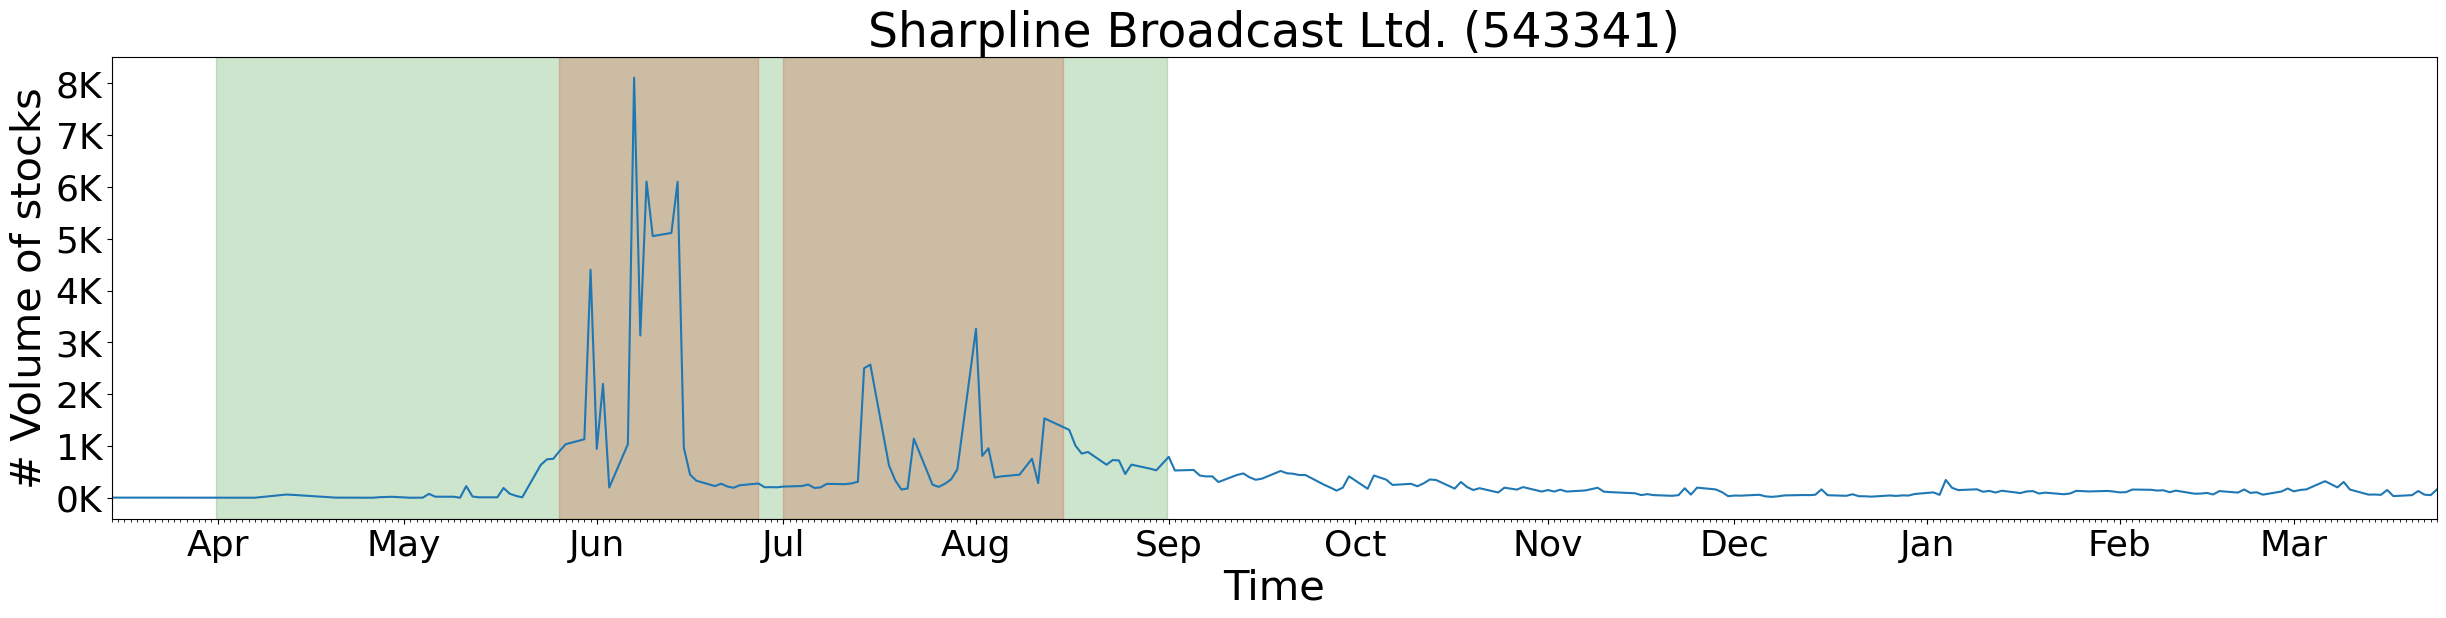

In [54]:
plot(data, 'Sharpline Broadcast Ltd. (543341)', anomalies=[anomalies, known_anomalies])

## LSTM with Dynamic Thresholding

In [11]:
hyperparameters = {
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        'target_column': 0
    },
    'keras.Sequential.LSTMTimeSeriesRegressor#1': {
        'epochs': 5,
        'verbose': True
    }
}

In [12]:
orion = Orion(
    pipeline='lstm_dynamic_threshold',
    hyperparameters=hyperparameters
)

In [13]:
anomalies = orion.fit(data)

Epoch 1/5
20/20 [==============================] - 8s 391ms/step - loss: 0.1107 - mse: 0.1107 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/5
20/20 [==============================] - 7s 347ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/5
20/20 [==============================] - 7s 347ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/5
20/20 [==============================] - 7s 350ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 5/5
20/20 [==============================] - 7s 348ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0028 - val_mse: 0.0028


In [14]:
anomalies

In [ ]:
plot(data, [anomalies, known_anomalies])

## TadGAN

In [3]:
parameters = {
  'mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1': {
    "interval": 3600
  },
  'orion.primitives.tadgan.TadGAN#1': {
    'epochs': 25,
  }
}

In [21]:
orion = Orion(
    'tadgan.json',
    parameters
)

In [ ]:
anomalies = orion.fit_detect(data)

In [59]:
anomalies

,start,end,severity
0,1654416000,1655352000,2.082489
1,1657537200,1658098800,0.828194
2,1659013200,1659650400,0.804128
3,1660392000,1660957200,0.178938


In [36]:
data_t = data[data.timestamp > 1640975400]

/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


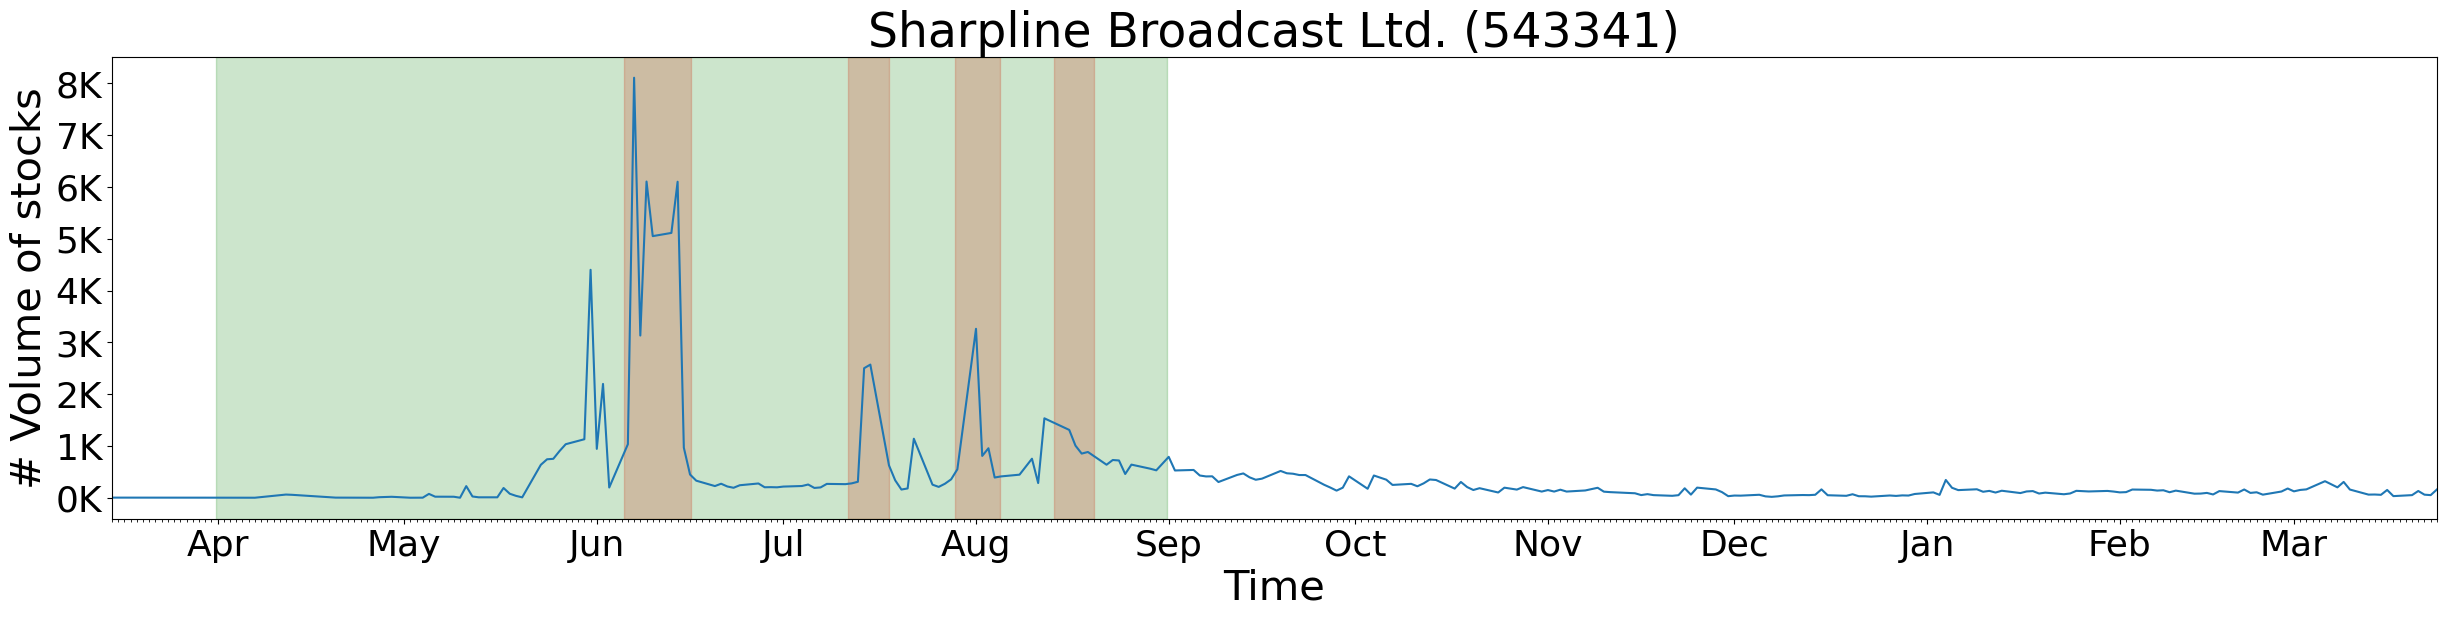

In [60]:
plot(data, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

In [61]:
orion.evaluate(data=data, ground_truth=known_anomalies,
               metrics=['f1', 'recall', 'precision'])

f1           0.339213
recall       0.204249
precision    1.000000
dtype: float64

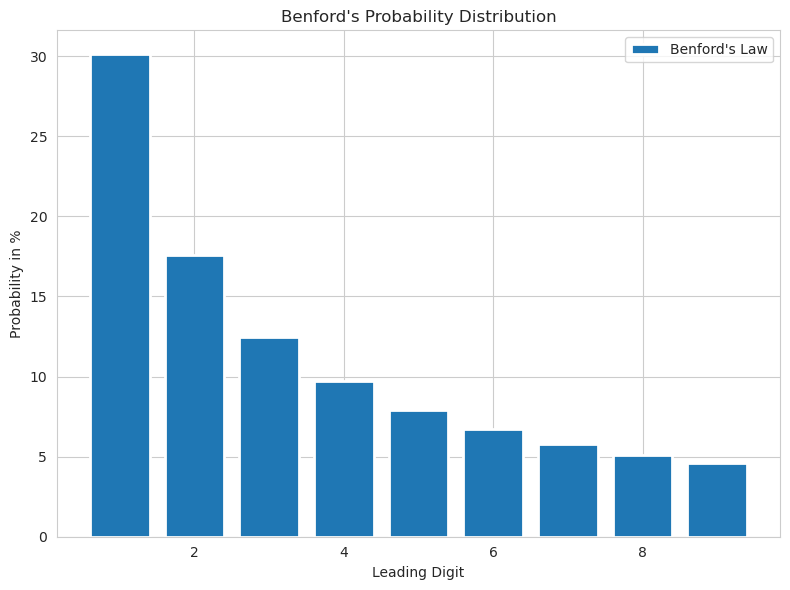

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def benfords_law():
    # Initialize a list to store the frequency of each digit (1-9)
    digit_frequencies = [0] * 9
    
    # Read the data from a file or generate your own data
    # For demonstration purposes, let's generate random numbers
    data = np.random.uniform(1, 1000, 1000)
    
    # Iterate through each data point
    for num in data:
        first_digit = int(str(num)[0])  # Get the first digit of the number
        
        # Increment the frequency of the corresponding digit
        digit_frequencies[first_digit - 1] += 1
        
    # Calculate the total count
    total_count = sum(digit_frequencies)
    
    # Calculate the expected Benford's Law frequencies
    benfords_frequencies = [np.log10(1 + (1 / digit)) * total_count for digit in range(1, 10)]
    log_frequencies = [np.log(digit_frequency) for digit_frequency in digit_frequencies]
    benfords_frequencies = [frequency/10 for frequency in benfords_frequencies]
    
    # Plot the results using seaborn
    digits = range(1, 10)
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 6))
    plt.bar(digits, benfords_frequencies, label="Benford's Law", linewidth=2)
    plt.xlabel('Leading Digit')
    plt.ylabel('Probability in %')
    plt.title("Benford's Probability Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to generate the graph
benfords_law()


/tmp/ipykernel_896748/853952884.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(digits, benfords_frequencies, 'r-', label="Benford's Law", linewidth=2, marker='o', markersize=6, color='salmon')
/tmp/ipykernel_896748/853952884.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


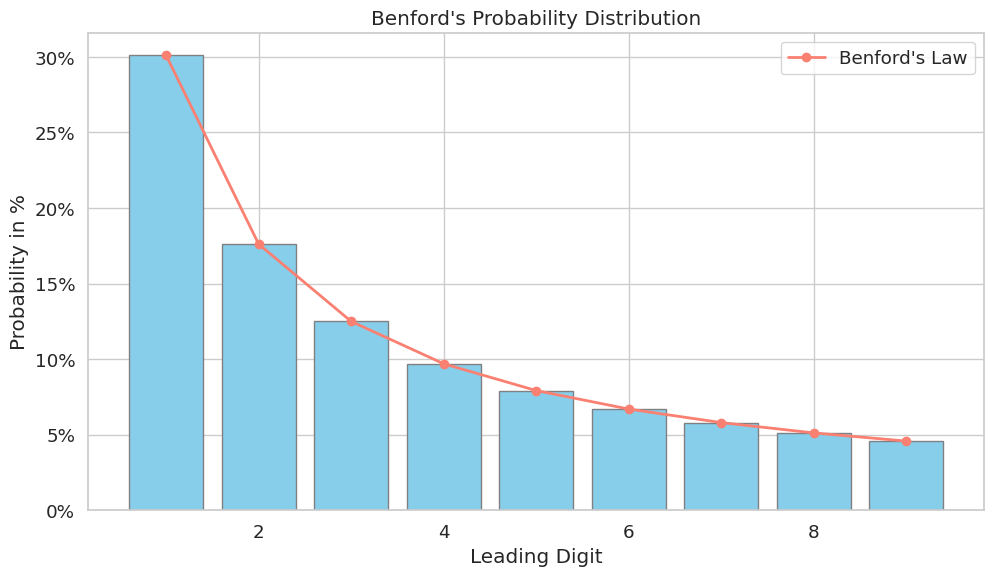

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def benfords_law():
    # Initialize a list to store the frequency of each digit (1-9)
    digit_frequencies = [0] * 9
    
    # Read the data from a file or generate your own data
    # For demonstration purposes, let's generate random numbers
    data = np.random.uniform(1, 1000, 1000)
    
    # Iterate through each data point
    for num in data:
        first_digit = int(str(num)[0])  # Get the first digit of the number
        
        # Increment the frequency of the corresponding digit
        digit_frequencies[first_digit - 1] += 1
        
    # Calculate the total count
    total_count = sum(digit_frequencies)
    
    # Calculate the expected Benford's Law frequencies
    benfords_frequencies = [np.log10(1 + (1 / digit)) * total_count for digit in range(1, 10)]
    benfords_frequencies = [frequency/10 for frequency in benfords_frequencies]
    
    # Plot the results using seaborn
    digits = range(1, 10)
    sns.set(style='whitegrid', font_scale=1.2)
    plt.figure(figsize=(10, 6))
    plt.bar(digits, benfords_frequencies, alpha=1, color='skyblue', edgecolor='gray')
    plt.plot(digits, benfords_frequencies, 'r-', label="Benford's Law", linewidth=2, marker='o', markersize=6, color='salmon')
    plt.xlabel('Leading Digit')
    plt.ylabel('Probability in %')
    plt.title("Benford's Probability Distribution")
    plt.legend()
    plt.tight_layout()
    # Show plt ticks in format {num}%
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    plt.show()


# Call the function to generate the graph
benfords_law()
